## Import thư viện

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from colorama import Fore
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA 

import math
warnings.filterwarnings('ignore')

## Load dữ liệu

In [80]:
df = pd.read_csv("clean data/hotel_clean.csv")
data = df[["Price", "Size", "Distance to beach", "Distance to airport", "Pool", "Bar",'Car','Non-smoking room',"Near beach",'WiFi','Family room','Breakfast']]
data

,Price,Size,Distance to beach,Distance to airport,Pool,Bar,Car,Non-smoking room,Near beach,WiFi,Family room,Breakfast
0,440,26,2.10,3.2,0,0,1,1,0,1,0,0
1,333,22,0.25,4.3,0,0,1,0,1,0,1,0
2,400,26,0.15,4.6,1,1,1,1,1,1,1,1
3,256,19,1.80,3.4,0,0,1,1,0,1,1,0
4,425,25,0.25,4.3,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1006,9000,1000,0.55,4.1,0,0,0,0,0,1,0,0
1007,4195,250,0.30,4.8,1,0,0,1,0,1,1,0
1008,5880,130,0.25,6.0,1,1,0,0,1,1,1,0
1009,9750,500,0.20,9.0,1,1,1,1,1,1,0,0


## Phân chia train set và val set

In [81]:
X = data.drop(["Price"] , axis=1)
y = data["Price"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

### Hàm này dùng để đánh giá mô hình

### Sử dụng 3 metrics: MAE, RMSE và MAPE để nhanh chóng đánh giá sơ bộ kết quả của mô hình

In [82]:

#this function used to evaluate the models.
def models_score(x_train, x_val, y_train, y_val):    
    models = {
        "Linear": LinearRegression(),
        "RandomForest":RandomForestRegressor(),
         }
    evalutes = {}
    i = 0
    maes = []
    rmse = []
    mape = []
    names = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred=model.predict(x_val) 
        names.append(name)
        maes.append(mean_absolute_error(y_val,y_pred))
        rmse.append(math.sqrt(mean_squared_error(y_val,y_pred)))
        mape.append(mean_absolute_percentage_error(y_val, y_pred))
    evalutes = {'Algorithms': names, 'MAE': maes, 'RMSE': rmse, "MAPE":mape}
    model_scores = pd.DataFrame(evalutes)
    # model_scores = model_scores.sort_values('MAE',ascending=False)
    return model_scores

## Feature Selection

### Đối vói mô hình Linear Regression

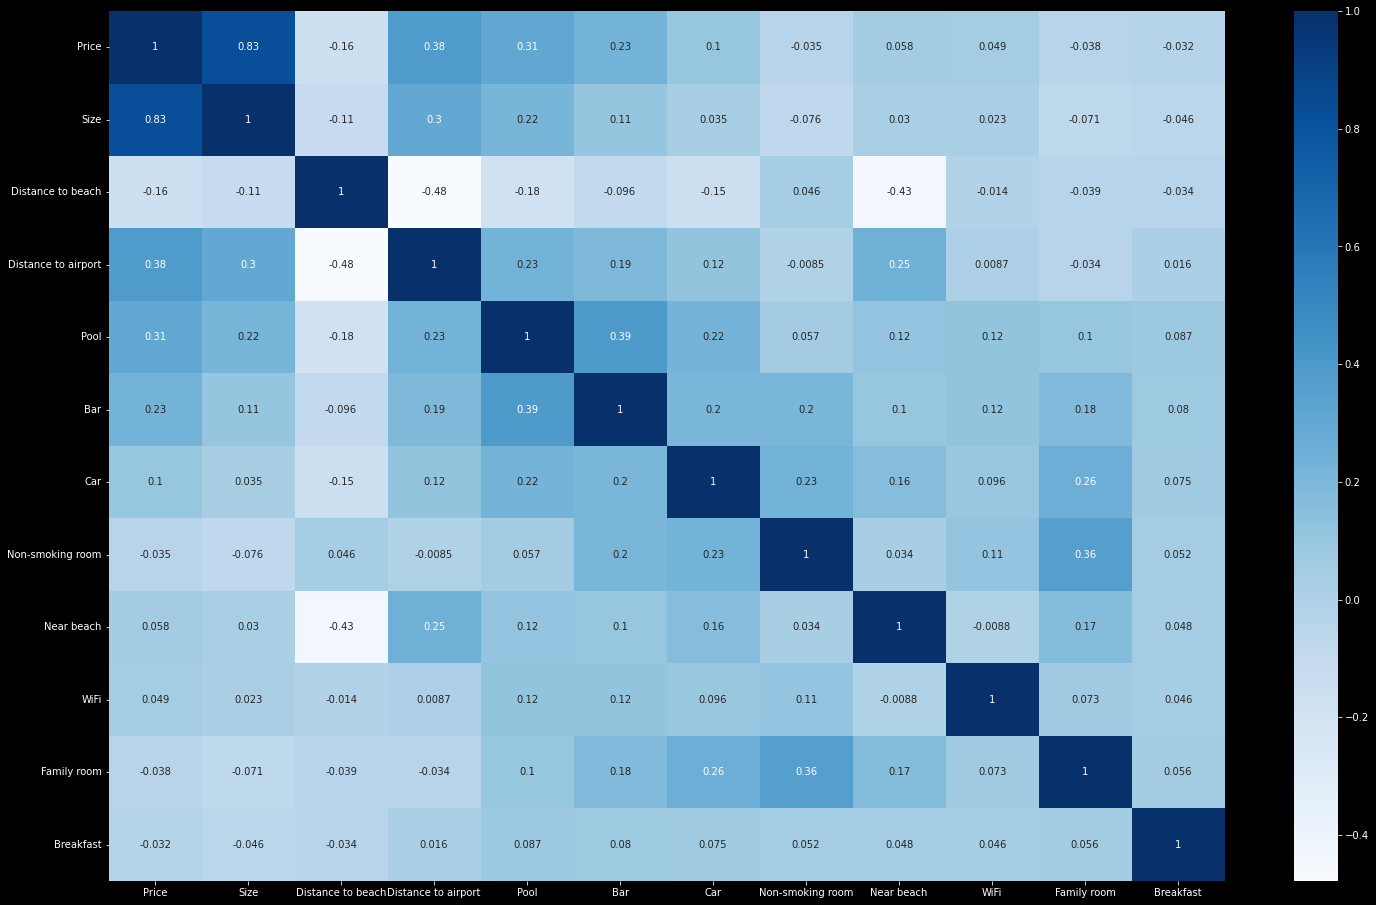

In [83]:
plt.figure(figsize = (25, 16))
dataplot = sns.heatmap(data.corr(), annot = True, cmap= "Blues")

### Từ correlation map, ta thấy top 3 các đặc trưng quan trọng cho mô hình Linear Regression là: 
- Size
- Distance to beach
- Distance to airport

### Đối với mô hình Random Forest


Feature: 0, Score: 0.77003
Feature: 1, Score: 0.08657
Feature: 2, Score: 0.08754
Feature: 3, Score: 0.01225
Feature: 4, Score: 0.00841
Feature: 5, Score: 0.01036
Feature: 6, Score: 0.00837
Feature: 7, Score: 0.00770
Feature: 8, Score: 0.00185
Feature: 9, Score: 0.00673
Feature: 10, Score: 0.00018


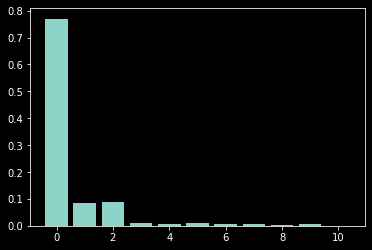

In [84]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Từ đây, ta thấy được 3 feature quan trọng cho mô hình random forest là: 
 - Size
 - Distance to beach
 - Distance to airport

### Ngoài ra, từ kết quả EDA, ta thấy 2 biến Pool và Bar cũng có ảnh hưởng đến biến mục tiêu, vậy nên ta sẽ chọn thêm 1 biến Pool (vì Pool có ảnh hưởng mạnh hơn)
=> Như vậy, 2 mô hình của chúng ta sẽ có 4 features:
- Size
- Distance to beach
- Distance to airport
- Pool

## Feature Extraction

### Trước tiên, chúng ta đánh giá model khi chưa thực hiện PCA

In [85]:
score = models_score(X_train, X_val, y_train, y_val)
score

,Algorithms,MAE,RMSE,MAPE
0,Linear,607.441192,1069.300857,0.643648
1,RandomForest,497.592831,984.871735,0.413358


### Sử dụng PCA để giảm chiều dữ liệu

In [86]:
scores = []
for i in range(1, 10):
  pca = PCA(n_components=i)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train)
  X_val_pca = pca.transform(X_val)
  scores.append(models_score(X_train_pca, X_val_pca, y_train, y_val))
  
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
best_model = scores[4]
best_model

,Algorithms,MAE,RMSE,MAPE
0,Linear,594.801542,1069.591403,0.614769
1,RandomForest,501.765234,1215.553484,0.388166


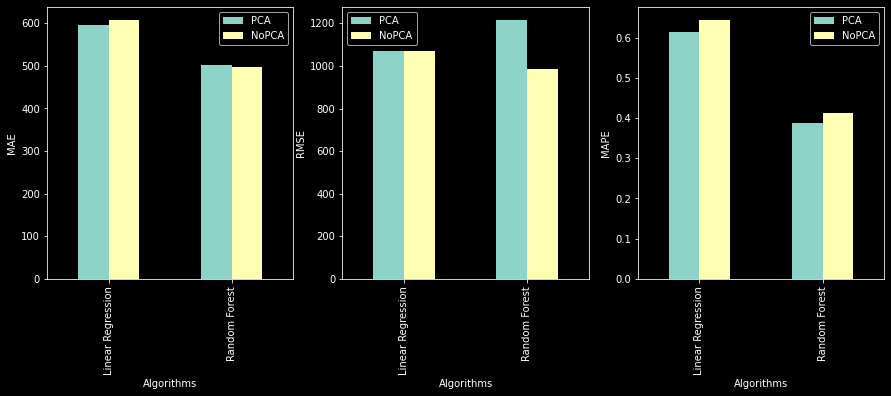

In [87]:
metrics = ["MAE", "RMSE", "MAPE"]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i in range(len(metrics)):
    df_comparea_pca = pd.DataFrame({
        'Algorithms': ["Linear Regression", "Random Forest"],
        'PCA': [best_model[metrics[i]][0], best_model[metrics[i]][1]],
        'NoPCA': [score[metrics[i]][0], score[metrics[i]][1]],
    })
    df_comparea_pca.plot(x="Algorithms", y=["PCA", "NoPCA"], kind="bar", ax = axs[i])
    axs[i].set_ylabel(metrics[i])


=> PCA không cải thiện nhiều hiệu suất mô hình, vậy nên chúng ta không áp dụng PCA

### Tạo thêm các biến mới
- Ở đây, chúng ta sẽ tạo thêm 2 biến mới:
    - Ratio: tỉ lệ giữa khoảng cách từ khách sạn đến biển và khoảng cách từ khách sạn đến sân bay
    - Facilities: số lượng các dịch vụ được ưa chuộng nhất mà khách sạn cung cấp
- Dựa trên kết quả EDA, chúng ta sẽ muốn Ratio sẽ có mối quan hệ nghịch biến với Price
- Theo thường thức, Facilities nên có quan hệ đồng biến với Price

In [88]:
def create_new_feature(X, fea):
    tmp = X.copy()
    if fea == "Ratio":
        tmp["Ratio"] = X["Distance to beach"] / X["Distance to airport"]
    elif fea == "Fac":
        facs = [ "Pool", "Bar",'Car','Non-smoking room','WiFi','Family room','Breakfast', "Near beach"]
        tmp["Facilities"] = X[facs].sum(axis =1)
    else:
        facs = [ "Pool", "Bar",'Car','Non-smoking room','WiFi','Family room','Breakfast', "Near beach"]
        tmp["Facilities"] = X[facs].sum(axis =1)
        tmp["Ratio"] = X["Distance to beach"] / X["Distance to airport"]
    return tmp

In [89]:
tmp_data = create_new_feature(data, "2")
tmp_data.corr()

,Price,Size,Distance to beach,Distance to airport,Pool,Bar,Car,Non-smoking room,Near beach,WiFi,Family room,Breakfast,Facilities,Ratio
Price,1.000000,0.830076,-0.164909,0.384179,0.306330,0.227594,0.104705,-0.034993,0.058262,0.049186,-0.038160,-0.032213,0.194401,-0.051582
Size,0.830076,1.000000,-0.105079,0.296037,0.216788,0.105783,0.035101,-0.076284,0.030093,0.022754,-0.070643,-0.046014,0.079618,-0.039015
Distance to beach,-0.164909,-0.105079,1.000000,-0.477759,-0.181876,-0.096419,-0.152920,0.046326,-0.430387,-0.013939,-0.038621,-0.034004,-0.257528,0.323886
Distance to airport,0.384179,0.296037,-0.477759,1.000000,0.227717,0.188360,0.121489,-0.008528,0.248651,0.008730,-0.033619,0.016225,0.224411,-0.247859
Pool,0.306330,0.216788,-0.181876,0.227717,1.000000,0.393270,0.222374,0.057487,0.115377,0.120663,0.101077,0.087355,0.580799,-0.088610
Bar,0.227594,0.105783,-0.096419,0.188360,0.393270,1.000000,0.204670,0.203763,0.103311,0.117530,0.184681,0.080074,0.620543,-0.045251
Car,0.104705,0.035101,-0.152920,0.121489,0.222374,0.204670,1.000000,0.227672,0.157294,0.095995,0.255461,0.074634,0.610568,-0.088180
Non-smoking room,-0.034993,-0.076284,0.046326,-0.008528,0.057487,0.203763,0.227672,1.000000,0.033653,0.114418,0.364817,0.052209,0.505911,-0.050499
Near beach,0.058262,0.030093,-0.430387,0.248651,0.115377,0.103311,0.157294,0.033653,1.000000,-0.008765,0.169506,0.047622,0.455447,-0.096217
WiFi,0.049186,0.022754,-0.013939,0.008730,0.120663,0.117530,0.095995,0.114418,-0.008765,1.000000,0.072881,0.045750,0.320179,-0.112549


- Từ bảng tương quan ta có thể thấy các dự đoán của chúng ta là tương đối chính xác
- Ở đây, vì 

In [90]:
X_train_new = create_new_feature(X_train, "2")
X_val_new = create_new_feature(X_val, "2")

In [91]:
score = models_score(X_train_new, X_val_new, y_train, y_val)
score

,Algorithms,MAE,RMSE,MAPE
0,Linear,610.019633,1068.325317,0.651081
1,RandomForest,486.190965,993.728815,0.389812


=> Không có sự cải thiện đáng kể về hiệu suất mô hình, vậy nên ta sẽ không tạo thêm các biến mới

## Feature Transformation

### Thực hiện Scaling bằng Robust Scaler vì dữ liệu chứa nhiều outlier

In [92]:
       
def scale_data(x):
    x = np.array(x)
    x = np.reshape(x, (len(x), 1))
    scaler = RobustScaler(quantile_range=(15,95))
    x = scaler.fit_transform(x)
    return x

In [93]:
models_score(X_train, X_val, y_train, y_val)

,Algorithms,MAE,RMSE,MAPE
0,Linear,607.441192,1069.300857,0.643648
1,RandomForest,497.283153,1038.620618,0.406911


### Thực hiện scale trên các biến numerical

In [94]:
features = ["Size", "Distance to beach", "Distance to airport"]
for feature in features:
    X_train[feature] = scale_data(X_train[[feature]])
    X_val[feature] = scale_data(X_val[feature])

## Xây dựng các class mô hình cho việc dự đoán và trình bày kết quả

In [115]:
class Model:
    def __init__(self):
        pass

    def predict(self, X_val):
        self.y_pred = self.model.predict(X_val)
        return self.y_pred
    
    
    
    def evaluate(self, y_true):
        self.score_mae = mean_absolute_error(y_true, self.y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, self.y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, self.y_pred)
        self.r2 = r2_score(y_true, self.y_pred)
        self.per = np.sum(np.abs(y_true-self.y_pred)/self.y_pred)/(len(self.y_pred))
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        print(Fore.GREEN + 'R2: {}'.format(self.r2))
        print(Fore.GREEN + '%: {}'.format(self.per))
        return self.score_mae, self.score_rmse, self.score_mape, self.r2
    
    def plot_result(self, width, height, X_val, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_val[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_val[:, 0].shape[0]), y=y_val, ax=ax, color='orange', label='Ground truth') 

        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        
        plt.show()

    def plot_yy(self, width, height, y_pred, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_val, y_pred, color='red')
        plt.plot(y_val, y_val)
        plt.grid()
        plt.xlabel('Actual price (Thousand VND)')
        plt.ylabel('Predicted price (Thousand VND)')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()
        
    def line_graph(self, width, height, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        x = np.arange(0, len(self.y_pred))
        sns.lineplot(x = x, y = self.y_pred, ax = ax, color = "yellow", label = "Predicted")
        sns.lineplot(x = x, y = y_val, ax = ax, color = "red", label="Actual")
        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}, R2: {self.r2}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.legend()
        
        
class ModelLinearRegression(Model):
    def __init__(self, regular = False):
        self.regular = regular
    def train(self, X_train, y_train):
        if not self.regular:
            self.model = LinearRegression()
        else:
            self.model = Ridge(alpha = 0.2)
        self.model.fit(X_train, y_train)
        

class ModelRandomForest(Model):
    def __init__(self, search=False):
        self.model = RandomForestRegressor()
        self.search = search
        self.params = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 20, 30],
                        'min_samples_split': [2, 4, 8],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [2, 3, 4],
                        'bootstrap': [True, False]
                    }
    def train(self, X_train, y_train):
        if not self.search:
            self.model.fit(X_train, y_train)
        else:
            grid_search = GridSearchCV(estimator=self.model, param_grid=self.params, cv=5, n_jobs=-1, verbose=2)
            grid_search.fit(X_train, y_train)
            self.params = grid_search.best_params_
            self.model = RandomForestRegressor(**self.params)
            self.model.fit(X_train, y_train)

### Kết quả của Linear Regression

MAE: 605.1122055560355
RMSE: 1069.6326472301466
MAPE: 0.6385726797956169
R2: 0.8020160438571122
%: 605.1122055560355


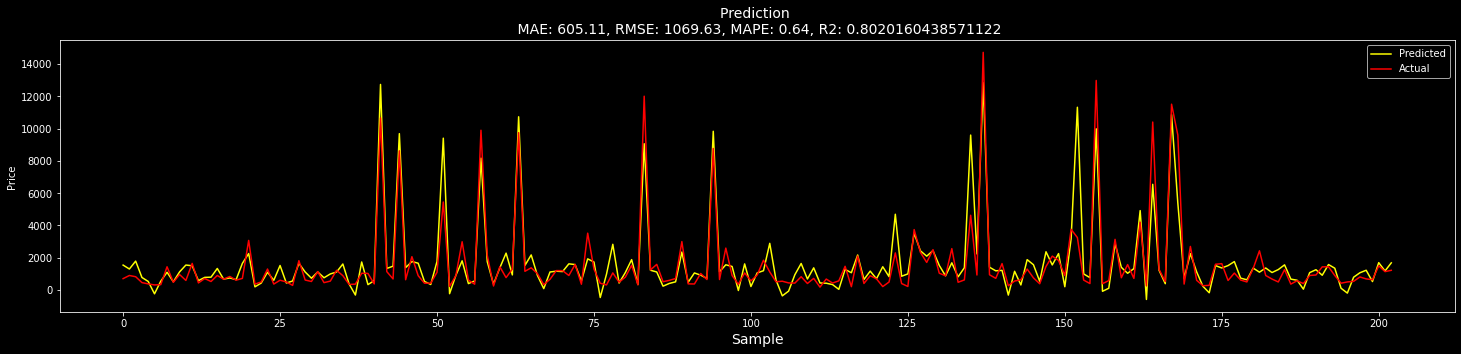

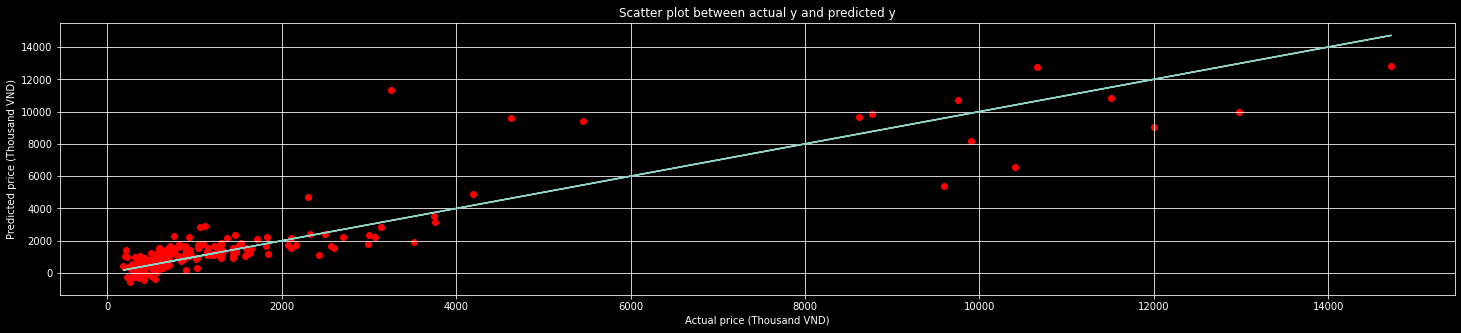

In [116]:
linear_reg = ModelLinearRegression(regular= True)
linear_reg.train(X_train_pca, y_train)
linear_y_pred = linear_reg.predict(X_val_pca)
linear_score_mae, linear_score_rmse, linear_score_mape, linear_r2 = linear_reg.evaluate(y_val)
linear_reg.line_graph(25, 5, y_val)
linear_reg.plot_yy(25, 5, linear_y_pred, y_val)

In [105]:
print(linear_reg.model.score(X_train, y_train))
print(linear_reg.model.score(X_val, y_val))

0.714297942945608
0.8020160438571122


- MAPE cao: kết quả dự đoán còn lệch nhiều so với kết quả thực, đặc biệt là ở các mẫu có Price cao (đa số là thấp hơn giá trị thực)
- Mô hình cho ra kết quả khá tốt với phân khúc khách sạn giá vừa và thấp (~2 triệu đồng)

MAE: 476.8431291930566
RMSE: 897.9776169124381
MAPE: 0.3682778388753281
R2: 0.8604622482499724
%: 1.0007975143797776


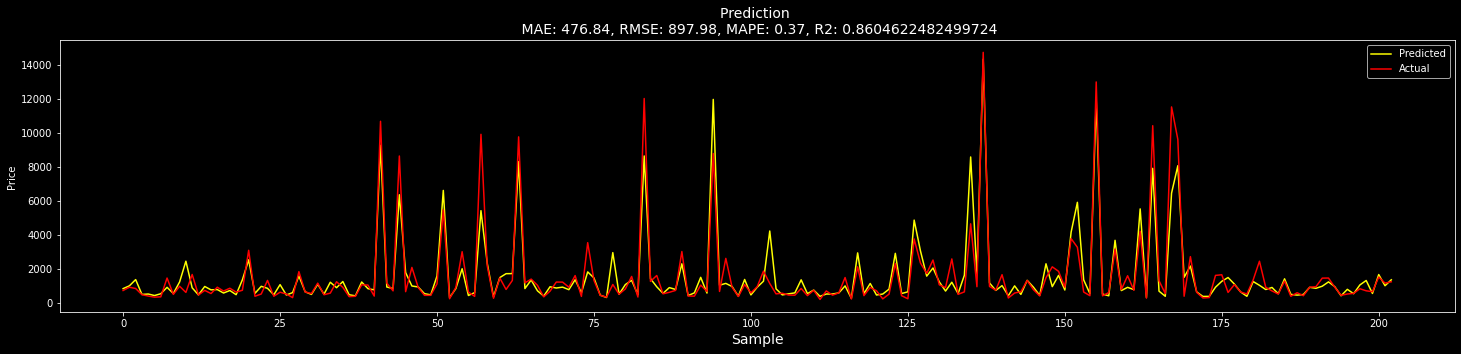

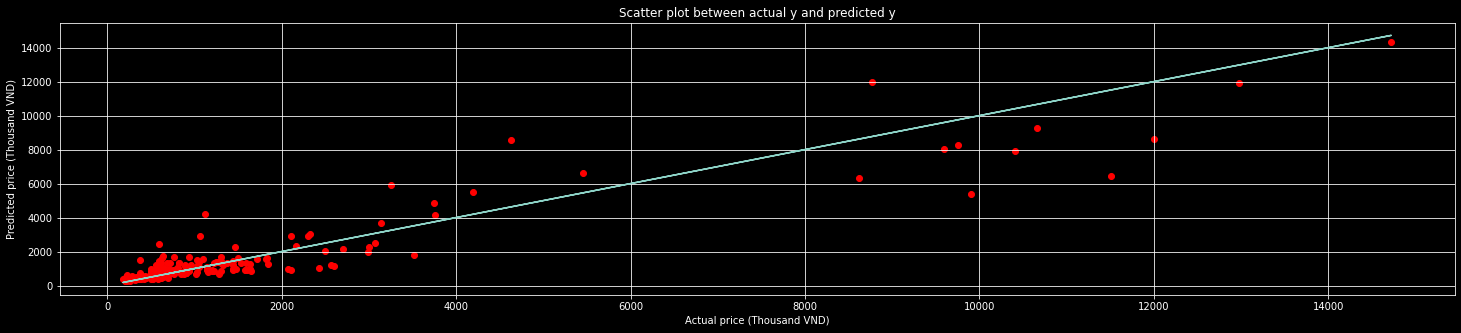

In [114]:
rdf = ModelRandomForest()
rdf.train(X_train, y_train)
rdf_y_pred = rdf.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf.evaluate(y_val)
rdf.line_graph(25, 5, y_val)
rdf.plot_yy(25, 5, rdf_y_pred, y_val)

In [104]:
print(rdf.model.score(X_train_pca, y_train))
print(rdf.model.score(X_val_pca, y_val))

0.9607250735688493
0.6785681685615553


- Random Forest nhìn chung cho dự đoán tốt hơn, đặc biệt là ở các mức giá cao

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
MAE: 483.4703286254353
RMSE: 900.4266037116525
MAPE: 0.3750995363003121
R2: 0.8597001087766902


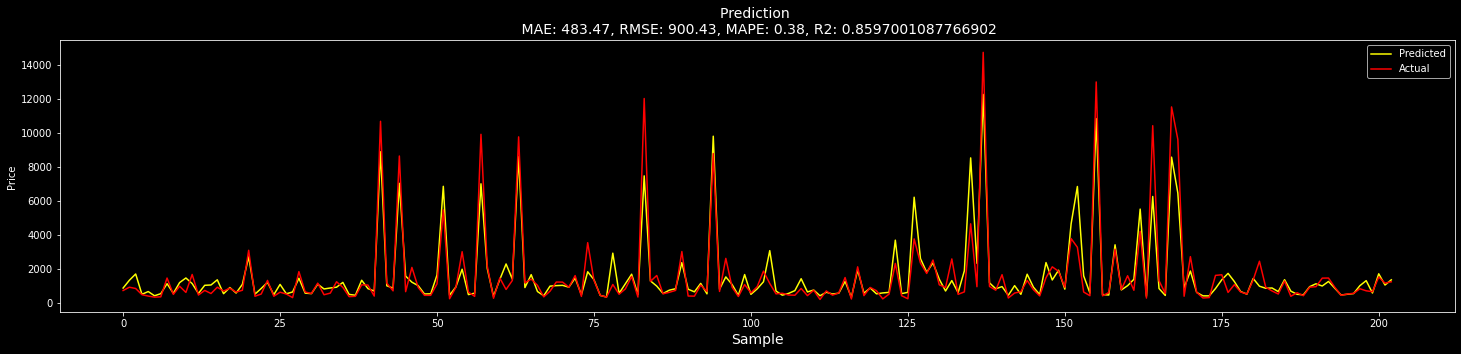

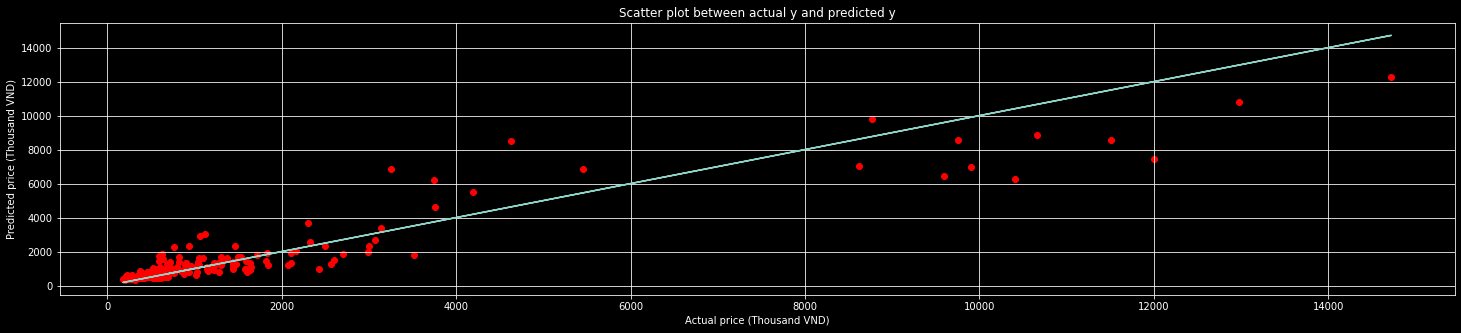

In [100]:
rdf_xg = ModelRandomForest(search = True)
rdf_xg.train(X_train, y_train)
rdf_xg_y_pred = rdf_xg.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf_xg.evaluate(y_val)
rdf_xg.line_graph(25, 5, y_val)
rdf_xg.plot_yy(25, 5, rdf_xg_y_pred, y_val)

- Grid Search nhìn chung không giúp tăng hiệu suất mô hình quá nhiều

## KẾT LUẬN
- Vì dữ liệu có nhiều outlier nên trước hết ta áp dụng Robust Scaler để mô hình có thể học tốt hơn.
- Áp dụng PCA không có quá nhiều cải thiện đối với hiệu suất mô hình
- Nhìn chung, Random Forest cho kết quả tốt hơn Linear Regression, đặc biệt là đối với các mức giá cao
- Kết quả dự đoán có thể chấp nhận được, có thể cải thiện hơn bằng nhiều cách như:
    - Thu thập thêm nhiều dữ liệu (đặc biệt là các khách sạn có các mức giá cao, trên 5 triệu đồng)
    - Thu thập và phân tích thêm nhiều đặc trưng
